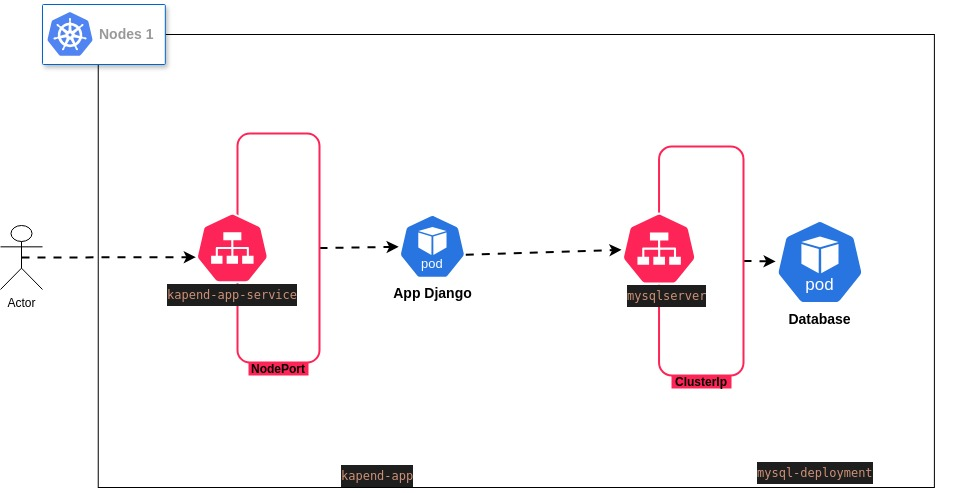
### 1. Base de données

db.yaml

- Deployment

```yaml
# Déploiement de MySQL
apiVersion: apps/v1
kind: Deployment
metadata:
  name: mysql-deployment
spec:
  replicas: 1
  selector:
    matchLabels:
      app: mysql-db
  template:
    metadata:
      labels:
        app: mysql-db
    spec:
      containers:
      - name: mysql-db
        image: mysql
        env:
          - name: MYSQL_ROOT_HOST
            value: '%'
          - name: MYSQL_ROOT_PASSWORD
            value: 'root'
          - name: MYSQL_DATABASE
            value: 'djangodb'

```

- Exposer le deployment avec un service

```yaml
# Service MySQL
apiVersion: v1
kind: Service
metadata:
  name: mysqlserver
spec:
  type: NodePort
  selector:
    app: mysql-db
  ports:
    - port: 3306
      targetPort: 3306
      nodePort: 30036
```

- Lancer d'abord la base de données

```shell
microk8s kubectl apply -f db.yaml
```

### 2. Application Django (app.yaml)

- Le deployment

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: kapend-app
spec:
  replicas: 1  # Valeur par défaut, ajustée par la commande de mise à l'échelle
  selector:
    matchLabels:
      app: kapend-app
  template:
    metadata:
      labels:
        app: kapend-app
    spec:
      containers:
      - name: kapend-app
        image: stark275/kapend:v2
        ports:
        - containerPort: 8000

```

- Exposer le deployment via un service

```yaml
apiVersion: v1
kind: Service
metadata:
  name: kapend-app-service
spec:
  selector:
    app: kapend-app
  type: NodePort
  ports:
  - port: 80  # Port externe exposé par le service
    targetPort: 8000  # Port sur les pods vers lequel le trafic est acheminé
    nodePort: 32043
```


- Ensuite l'application étant données que cette dernière dépend de la BD

```shell
microk8s kubectl apply -f app.yaml
```

### Ajout des volumes pour persister les données
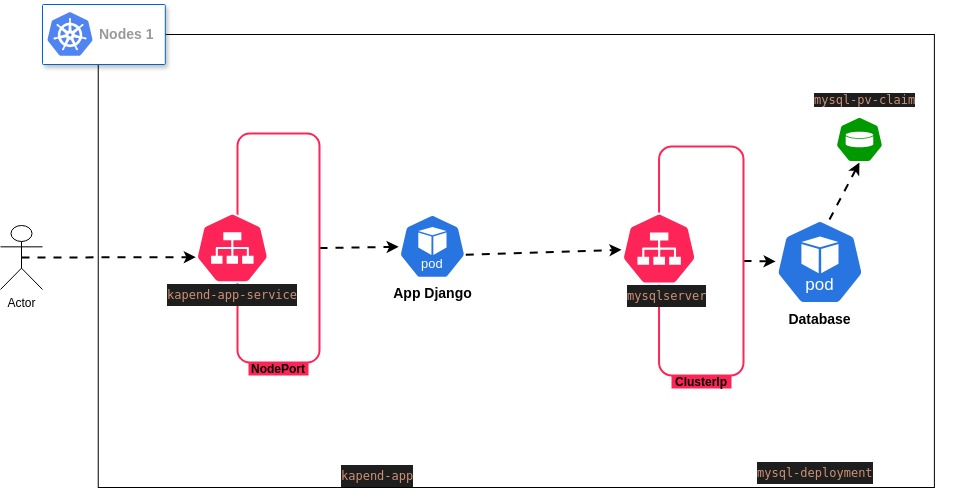
- D'abord arreter les services

```shell
microk8s kubectl delete -f db.yaml
microk8s kubectl delete -f app.yaml
```

- Créer un manifeste separé pour nos volumes (volumes.yaml)

```yaml
apiVersion: v1
kind: PersistentVolume
metadata:
  name: mysql-pv
spec:
  capacity:
    storage: 2Gi
  accessModes:
    - ReadWriteOnce
  hostPath:
    path: "/var/lib/mysql"

---

apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: mysql-pv-claim
spec:
  accessModes:
    - ReadWriteOnce
  resources:
    requests:
      storage: 2Gi
```

- Modifier le deployment mysql pour qu'il utilise les volumes crées

```yaml
# Déploiement de MySQL
apiVersion: apps/v1
kind: Deployment
metadata:
  name: mysql-deployment
spec:
  replicas: 1
  selector:
    matchLabels:
      app: mysql-db
  template:
    metadata:
      labels:
        app: mysql-db
    spec:
      containers:
      - name: mysql-db
        image: mysql
        env:
          - name: MYSQL_ROOT_HOST
            value: '%'
          - name: MYSQL_ROOT_PASSWORD
            value: 'root'
          - name: MYSQL_DATABASE
            value: 'djangodb'
        volumeMounts:
        - name: mysql-data
          mountPath: /var/lib/mysql
        # - name: mysql-config-volume
        #   mountPath: /etc/mysql/conf.d/
      volumes:
      - name: mysql-data
        persistentVolumeClaim:
          claimName: mysql-pv-claim
      # - name: mysql-config-volume
      #   configMap:
      #     name: mysql-config
```



### Ajouter un Ingress
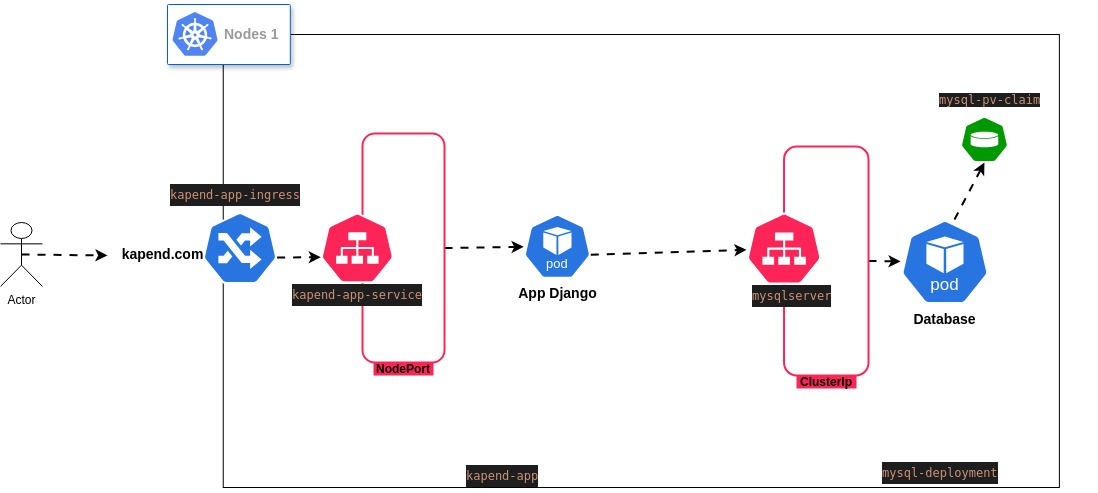
- Installer l'ingress Controller par défaut de microk8s (nginx-ingress)

```shell
microk8s enable ingress
```

- Créer les règles Ingress

```yaml
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: kapend-app-ingress
  annotations:
    nginx.ingress.kubernetes.io/rewrite-target: /
spec:
  rules:
  - host: kapend.com
    http:
      paths:
      - path: /
        pathType: Prefix
        backend:
          service:
            name: kapend-app-service
            port:
              number: 80
```

NB: Le domaine `kapend.com` doit etre valide. Pour utiliser ce domaine en local on peut utiliser les virtual hosts

1. Sur linux ajouter l'ip du noeud kubernetes par lequel vous accedez à l'application, dans /etc/hosts 
 `192.168.113.120 kapend.com` 

 Votre fichier doit ressembler à ceci:

 ```
 127.0.0.1       localhost
 127.0.1.1       kheops
 192.168.113.102 kapend.com
 ```

Mais Si votre instance de microk8s est installer sur votre PC local alors `kapend.com` doit pointer sur 127.0.0.1

```
 127.0.0.1       localhost
 127.0.1.1       kheops
 127.0.0.1       kapend.com
 ```

Vérifiez que le contrôleur Ingress est en cours d’exécution en listant tous les pods dans le cluster avec la commande suivante

```shell
microk8s kubectl get pods -A | grep ingress
```

### Utiliser les secrets et les configMaps

Dans config.yaml
```yaml

apiVersion: v1
kind: Secret
metadata:
  name: mysql-db-secret
type: Opaque
data:
  # Les valeurs doivent être encodées en base64
  root-password: cm9vdA==  # 'root' encodé en base64

```
**NB: Sur Linux et MacOs remplacez 'root' par votre valeur pour avoir la valeur en base 64: `echo -n 'root' | base64`**

Puis

```yaml
apiVersion: v1
kind: ConfigMap
metadata:
  name: mysql-db-config
data:
  MYSQL_ROOT_HOST: '%'
  MYSQL_DATABASE: 'djangodb'
  my.cnf: |
    [mysqld]
    lower_case_table_names=1
```

app.yaml devient

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: mysql-deployment
spec:
  replicas: 1
  selector:
    matchLabels:
      app: mysql-db
  template:
    metadata:
      labels:
        app: mysql-db
    spec:
      containers:
      - name: mysql-db
        image: mysql
        envFrom:
        - configMapRef:
            name: mysql-db-config
        env:
          - name: MYSQL_ROOT_PASSWORD
            valueFrom:
              secretKeyRef:
                name: mysql-db-secret
                key: root-password
        volumeMounts:
        - name: mysql-data
          mountPath: /var/lib/mysql
        - name: mysql-config-volume
          mountPath: /etc/mysql/conf.d/
      volumes:
      - name: mysql-data
        persistentVolumeClaim:
          claimName: mysql-pv-claim
      - name: mysql-config-volume
        configMap:
          name: mysql-db-config
```


Appliquer la configuration

- D'abord arreter les services

```shell
microk8s kubectl delete -f db.yaml
microk8s kubectl delete -f app.yaml
```

Appliquer le secrets et le configMap dans config.yaml

```yaml
apiVersion: v1
kind: Secret
metadata:
  name: mysql-db-secret
type: Opaque
data:
  # Les valeurs doivent être encodées en base64
  root-password: cm9vdA==  # 'root' encodé en base64

---

apiVersion: v1
kind: ConfigMap
metadata:
  name: mysql-db-config
data:
  MYSQL_ROOT_HOST: '%'
  MYSQL_DATABASE: 'djangodb'
  my.cnf: |
    [mysqld]
    lower_case_table_names=1
```

```shell
microk8s kubectl apply -f config.yaml
```

- Puis relancer les services

```shell
microk8s kubectl apply -f db.yaml
microk8s kubectl apply -f app.yaml
```


### Lancer les pod de l'application Django seulement si la base de donnée est prete

```yaml

```